In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce
from collections import OrderedDict 
import time
np.set_printoptions(threshold=sys.maxsize)

In [2]:
trueHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5"

trueHitsFile = h5py.File(trueHitsPath,"r")

trueHitsListArr = np.load('trueHitsListArr.npy', allow_pickle = True)

trueHitParent = trueHitsFile["hit_parent"]

In [16]:
multiSource = []
totalPMTs = 0
oneParent = 0
twoParent = 0
threeParent = 0
errorParent = 0
percentParents = [] # index = arbitrary, value = [event, %parent1, %parent2, %parent3]

# step through all events
#for e in range(5000):
for e in range(len(trueHitsListArr)):
    allParents = []
    hits = np.array(trueHitsListArr[e])

    # step through pmt hits in each event - determine parents
    for h in hits:
        parents = trueHitsFile["hit_parent"][h]
        totalPMTs += 1
    
        # check if pmt has multiple parents
        try:
            l = len(parents)
        except:
            l = 1
        finally:
            if l != 1:
                multiSource.append([e, h, parents])
            else:
                allParents.append(parents)
    
    # get percent contribution of each parent for one event
    def getParents(allParents,e):
        parentIndex = [-1,2,3]
        num1 = 0
        num2 = 0
        num3 = 0
        
        for p in allParents:
            if p == parentIndex[0]:
                num1 += 1
            elif p == parentIndex[1]:
                num2 += 1
            elif p == parentIndex[2]:
                num3 += 1
        
        percentParents.append([e,(num1/len(allParents)),(num2/len(allParents)),(num3/len(allParents))])
 
        return num1,num2,num3
    
    
    # check multiple sources from single event
    num1,num2,num3 = getParents(allParents,e)
    
    uniqueParents = np.unique(allParents)
    if len(uniqueParents) == 1:
        oneParent += 1
    elif len(uniqueParents) == 2:
        twoParent += 1
    elif len(uniqueParents) == 3:
        threeParent += 1
    else:
        errorParent += 1


print("1:",oneParent)
print("2:",twoParent)
print("3:",threeParent)
print("error:",errorParent)

1: 1349533
2: 201295
3: 1589
error: 6


In [4]:
# generate histogram
def certainty(per):
    total = 0
    for i in range(len(percentParents)):
        if percentParents[i][1] != 1 and percentParents[i][2] != 1 and percentParents[i][3] != 1:
            if percentParents[i][1] >= per or percentParents[i][2] >= per or percentParents[i][3] >= per:
                total += 1
    return total


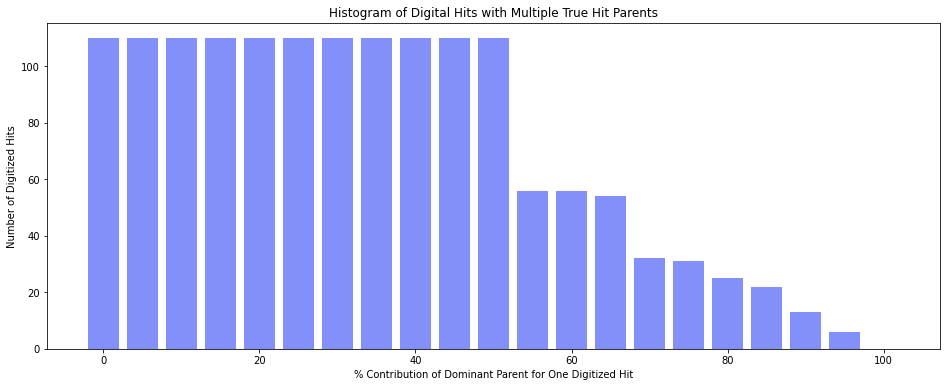

In [5]:
fig, ax = plt.subplots(1, figsize=(16, 6))
z = np.arange(0,105,5)

for num in z:
    plt.bar(num,(certainty(num/100)), color='#8390FA', width=4)

plt.title("Histogram of Digital Hits with Multiple True Hit Parents")
plt.xlabel("% Contribution of Dominant Parent for One Digitized Hit")
plt.ylabel("Number of Digitized Hits")
plt.show()

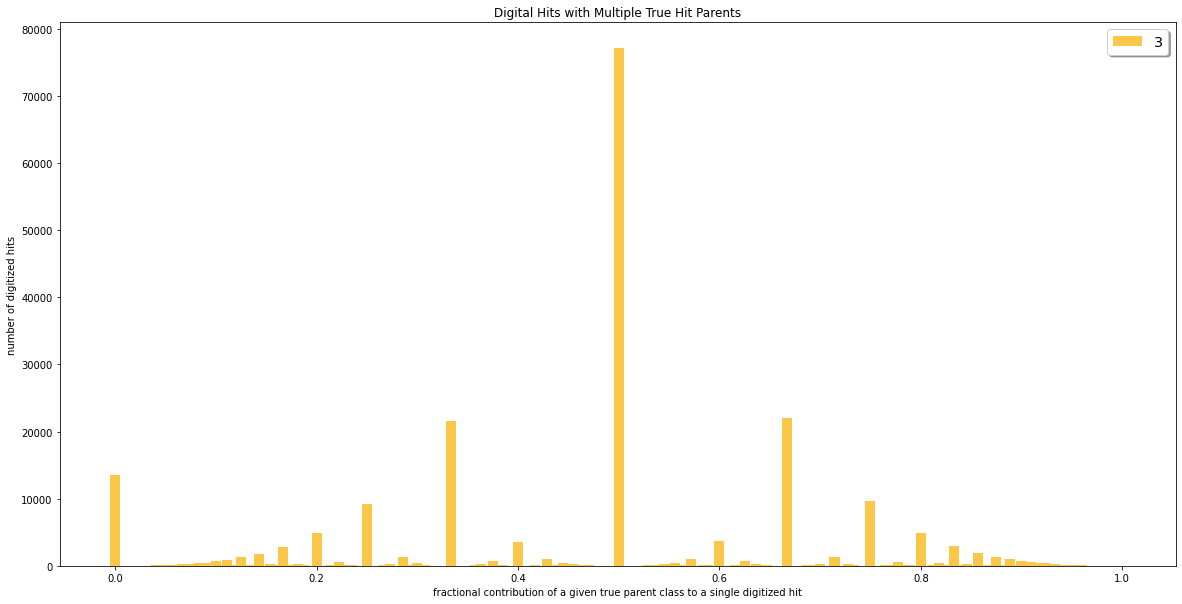

In [18]:
# second histogram for Patrick
p1 = []
p2 = []
p3 = []

for i in range(len(percentParents)):
    if percentParents[i][1] != 1 and percentParents[i][2] != 1 and percentParents[i][3] != 1:
        p1.append(percentParents[i][1])
        p2.append(percentParents[i][2])
        p3.append(percentParents[i][3])

pp1 = np.unique(p1)
pp2 = np.unique(p2)
pp3 = np.unique(p3)

def ppC(pp,p):
    c = np.zeros(len(pp))
    for i in range(len(pp)):
        for j in range(len(p)):
            if p[j] == pp[i]:
                c[i] += 1
    return c

c1 = ppC(pp1,p1)
c2 = ppC(pp2,p2)
c3 = ppC(pp3,p3)


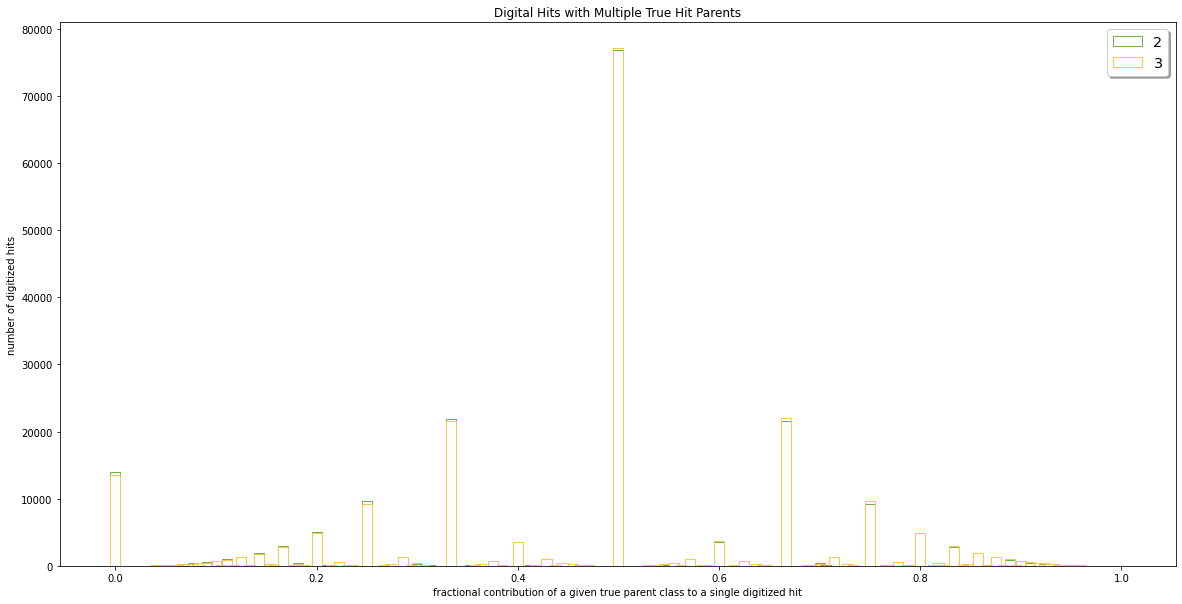

In [40]:
fig, ax = plt.subplots(1, figsize=(20, 10))
colors = ['#8390FA', '#6EAF46', '#FAC748']

#plt.bar(pp1,c1,edgecolor=colors[0],color='none',width=0.01,label='-1')
plt.bar(pp2,c2,edgecolor=colors[1],color='none',width=0.01,label='2')
plt.bar(pp3,c3,edgecolor=colors[2],color='none',width=0.01,label='3')

plt.title("Digital Hits with Multiple True Hit Parents")
plt.xlabel("fractional contribution of a given true parent class to a single digitized hit")
plt.ylabel("number of digitized hits")
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()